In [206]:
#mathematical operations
import math
import scipy as sp
import numpy as np

#data handling
import pandas as pd

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
sns.set()

#machine learning and statistical methods
import statsmodels.api as sm

#dataframe index manipulations
import datetime

#selected preprocessing and evaluation methods
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit


#muting unnecessary warnings if needed
import warnings

In [207]:
data = pd.read_csv('Historical_data.csv')

In [208]:
df_data = data.copy()

In [209]:
#df_data.Date = pd.to_datetime(df_data.Date, dayfirst = True)
#df_data.set_index("Date", inplace=True)

In [210]:
df_data.tail()

,Date,Temp C,Holiday,Demand
2154,31/03/2017 20:00,13.43,0,5.22
2155,31/03/2017 21:00,12.14,0,4.96
2156,31/03/2017 22:00,10.29,0,4.78
2157,31/03/2017 23:00,8.21,0,4.73
2158,01/04/2017 00:00,7.29,0,4.48


In [211]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159 entries, 0 to 2158
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2159 non-null   object 
 1   Temp C   2159 non-null   float64
 2   Holiday  2159 non-null   int64  
 3   Demand   2159 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 67.6+ KB


# Visual representation of the price data set

<AxesSubplot:xlabel='Date'>

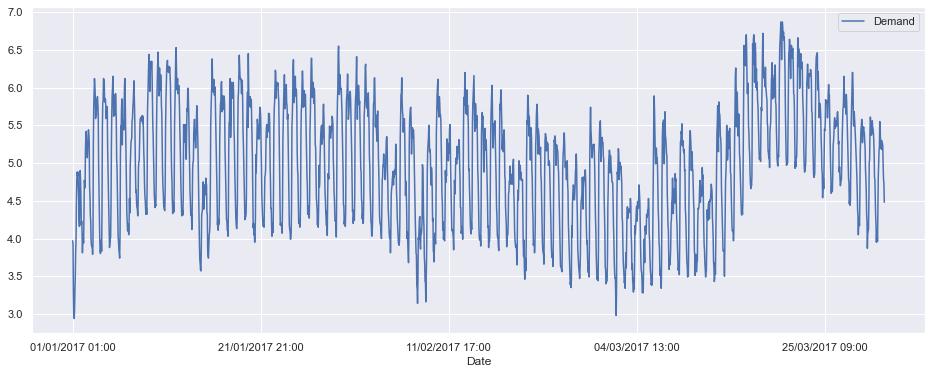

In [212]:
df_data.plot(x='Date', y='Demand', figsize = (16, 6), legend = True)

# Zoom in for inspection 

<AxesSubplot:xlabel='Date'>

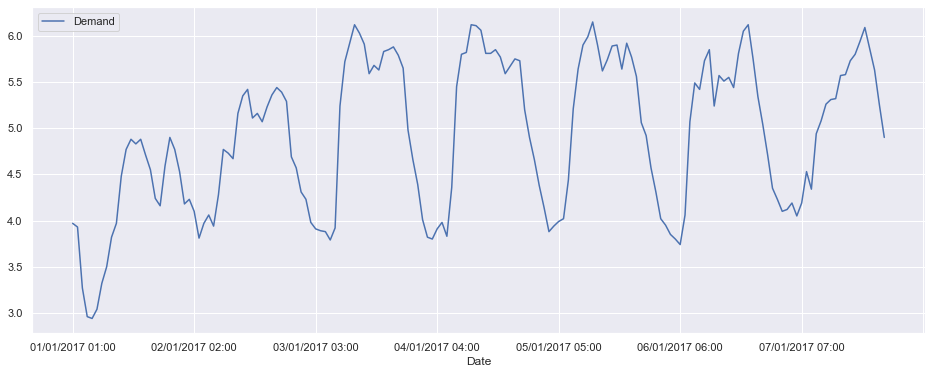

In [213]:
data_copy = data.copy()
data_copy[:168].plot(x='Date', y='Demand', figsize = (16, 6), legend = True)

There is visibal cyclical behaviour of the price dependent on the time

In [214]:
df_data.head()

,Date,Temp C,Holiday,Demand
0,01/01/2017 01:00,-4.71,1,3.97
1,01/01/2017 02:00,-5.64,1,3.93
2,01/01/2017 03:00,-6.14,1,3.27
3,01/01/2017 04:00,-6.00,1,2.96
4,01/01/2017 05:00,-6.71,1,2.94


# Working days demand summary

In [215]:
working_days = df_data.where(df_data['Holiday'] < 1, df_data['Demand'], axis = 1)
working_days['Demand'].describe()

count    2087.000000
mean        5.006430
std         0.793818
min         2.980000
25%         4.360000
50%         5.040000
75%         5.630000
max         6.870000
Name: Demand, dtype: float64

# Holidays demand summary

In [216]:
holiday_days = df_data.where(df_data['Holiday'] > 0, df_data['Demand'], axis = 1)
holiday_days['Demand'].describe()


count    72.000000
mean      4.295139
std       0.633519
min       2.940000
25%       3.902500
50%       4.350000
75%       4.740000
max       5.440000
Name: Demand, dtype: float64

The demand during holidays is 15% lower on average

# Price rolling mean vs Temperature rolling mean

In [217]:
df_data_temp = data['Temp C'].rolling(100).mean()
df_data_prices = data['Demand'].rolling(100).mean()

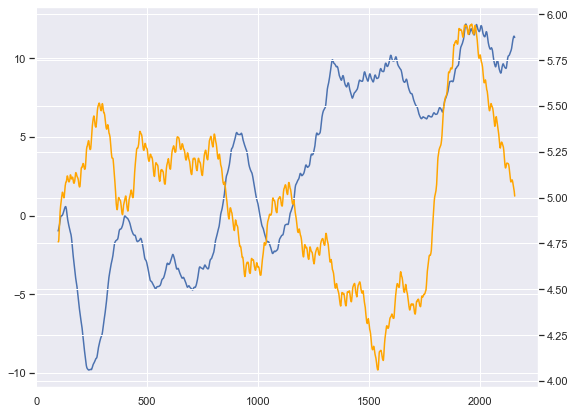

In [218]:
fig, ax = plt.subplots(figsize=[9, 7])
ax.plot(df_data.index.values, df_data['Temp C'].rolling(100).mean(), color='b')
ax2 = ax.twinx()
ax2.plot(df_data.index.values, df_data['Demand'].rolling(100).mean(), color='orange')
plt.show()

For the current data it seems there is negative correlations for temperature bellow 0 degrees

In [219]:
df_data['Temp_MA100'] = data['Temp C'].rolling(100).mean()
df_data['Demand_MA100'] = data['Demand'].rolling(100).mean()

In [220]:
df_data.corr()

,Temp C,Holiday,Demand,Temp_MA100,Demand_MA100
Temp C,1.000000,-0.054131,0.087849,0.825490,-0.100855
Holiday,-0.054131,1.000000,-0.159843,0.106767,-0.136685
Demand,0.087849,-0.159843,1.000000,-0.137614,0.519588
Temp_MA100,0.825490,0.106767,-0.137614,1.000000,-0.209711
Demand_MA100,-0.100855,-0.136685,0.519588,-0.209711,1.000000


In [221]:
df_data

,Date,Temp C,Holiday,Demand,Temp_MA100,Demand_MA100
0,01/01/2017 01:00,-4.71,1,3.97,NaN,NaN
1,01/01/2017 02:00,-5.64,1,3.93,NaN,NaN
2,01/01/2017 03:00,-6.14,1,3.27,NaN,NaN
3,01/01/2017 04:00,-6.00,1,2.96,NaN,NaN
4,01/01/2017 05:00,-6.71,1,2.94,NaN,NaN
...,...,...,...,...,...,...
2154,31/03/2017 20:00,13.43,0,5.22,11.4077,5.0518
2155,31/03/2017 21:00,12.14,0,4.96,11.4170,5.0425
2156,31/03/2017 22:00,10.29,0,4.78,11.4020,5.0338
2157,31/03/2017 23:00,8.21,0,4.73,11.3691,5.0220


Correlation between temperature and demand on hourly bases 0.087849


Correlation between Demand MA and temperature MA is -0.209711

# Hyperparameters search

Searching for proper ARIMA parameters with the help of ACF PACF plots

Test for stationarity of the data with ADF test PACF plots

# ADF (Augmented Dickey Fuller test)

In [222]:
ad_fuller_result = adfuller(data['Demand'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
pvalue = ad_fuller_result[1]
if pvalue < 0.05:
    print('stationary')
else:
    print('not stationary')

ADF Statistic: -3.547335691897316
p-value: 0.006851450836150055
stationary


ACF plot:

C:\Users\manov\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


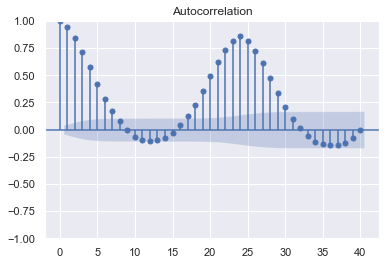

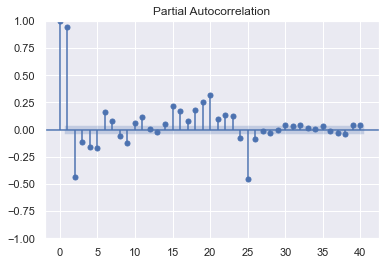

In [223]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['Demand'], lags=40)
plot_pacf(data['Demand'], lags=40)
plt.show()

AR processes are recognized by:

    • Exponentially decaying partial autocorrelation

    • Partial autocorrelation decaying toward zero

    • Swings between negative and positive partial autocorrelation

MA processes are identified by:

    • Sudden spikes in the ACF and PACF

In [224]:
model_ar_1_i_1_ma_1 = ARIMA(data['Demand'], order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Demand   No. Observations:                 2159
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -47.108
Date:                Sun, 29 May 2022   AIC                            100.215
Time:                        23:31:45   BIC                            117.246
Sample:                             0   HQIC                           106.445
                               - 2159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5130      0.056      9.220      0.000       0.404       0.622
ma.L1         -0.1431      0.059     -2.441      0.015      -0.258      -0.028
sigma2         0.0612      0.001     46.370      0.000       0.059       0.064
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               926.71
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.99
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [225]:
model_ar_8_i_1_ma_0 = ARIMA(data['Demand'], order=(24,1,0))
results_ar_8_i_1_ma_0 = model_ar_8_i_1_ma_0.fit()
results_ar_8_i_1_ma_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Demand   No. Observations:                 2159
Model:                ARIMA(24, 1, 0)   Log Likelihood                 782.558
Date:                Sun, 29 May 2022   AIC                          -1515.117
Time:                        23:31:52   BIC                          -1373.193
Sample:                             0   HQIC                         -1463.206
                               - 2159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0161      0.016     -1.041      0.298      -0.047       0.014
ar.L2         -0.0713      0.018     -3.876      0.000      -0.107      -0.035
ar.L3         -0.0820      0.019     -4.271      0.000      -0.120      -0.044
ar.L4         -0.0385      0.019     -1.976      0.048      -0.077      -0.000
ar.L5         -0.1758      0.019     -9.122      0.000      -0.214      -0.138
ar.L6         -0.1378      0.019     -7.074      0.000      -0.176      -0.100
ar.L7         -0.0970      0.019     -5.138      0.000      -0.134      -0.060
ar.L8         -0.0444      0.020     -2.265      0.023      -0.083      -0.006
ar.L9         -0.1370      0.020     -6.761      0.000      -0.177      -0.097
ar.L10        -0.1534      0.020     -7.704      0.000      -0.192      -0.114
ar.L11        -0.0992      0.020     -5.017      0.000      -0.138      -0.060
ar.L12        -0.0838      0.020     -4.118      0.000      -0.124      -0.044
ar.L13        -0.0737      0.021     -3.506      0.000      -0.115      -0.033
ar.L14        -0.1433      0.021     -6.940      0.000      -0.184      -0.103
ar.L15        -0.1194      0.020     -5.994      0.000      -0.158      -0.080
ar.L16        -0.0861      0.020     -4.214      0.000      -0.126      -0.046
ar.L17        -0.1041      0.020     -5.139      0.000      -0.144      -0.064
ar.L18        -0.1120      0.019     -5.754      0.000      -0.150      -0.074
ar.L19        -0.1772      0.020     -8.825      0.000      -0.217      -0.138
ar.L20        -0.0602      0.020     -3.028      0.002      -0.099      -0.021
ar.L21        -0.0694      0.019     -3.618      0.000      -0.107      -0.032
ar.L22        -0.0697      0.019     -3.672      0.000      -0.107      -0.032
ar.L23         0.0644      0.019      3.399      0.001       0.027       0.102
ar.L24         0.4541      0.016     28.655      0.000       0.423       0.485
sigma2         0.0282      0.001     44.904      0.000       0.027       0.029
===================================================================================
Ljung-Box (L1) (Q):                   2.82   Jarque-Bera (JB):               624.96
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.48
Prob(H) (two-sided):                  0.75   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [226]:
model_ar_1_i_1_ma_0_X = sm.tsa.statespace.SARIMAX(data['Demand'], order=(8,1,1), exog=data['Temp C']) 
res = model_ar_1_i_1_ma_0_X.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Demand   No. Observations:                 2159
Model:               SARIMAX(8, 1, 1)   Log Likelihood                  69.348
Date:                Sun, 29 May 2022   AIC                           -116.697
Time:                        23:31:54   BIC                            -54.251
Sample:                             0   HQIC                           -93.856
                               - 2159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp C         0.0192      0.010      1.870      0.061      -0.001       0.039
ar.L1         -0.0207      0.274     -0.076      0.940      -0.558       0.516
ar.L2          0.1610      0.094      1.711      0.087      -0.023       0.345
ar.L3          0.0784      0.026      2.973      0.003       0.027       0.130
ar.L4          0.1490      0.030      5.033      0.000       0.091       0.207
ar.L5         -0.1615      0.047     -3.408      0.001      -0.254      -0.069
ar.L6         -0.2270      0.061     -3.694      0.000      -0.347      -0.107
ar.L7         -0.0898      0.045     -2.016      0.044      -0.177      -0.002
ar.L8          0.0649      0.028      2.321      0.020       0.010       0.120
ma.L1          0.3583      0.274      1.305      0.192      -0.180       0.896
sigma2         0.0549      0.001     46.028      0.000       0.053       0.057
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1302.59
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             1.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

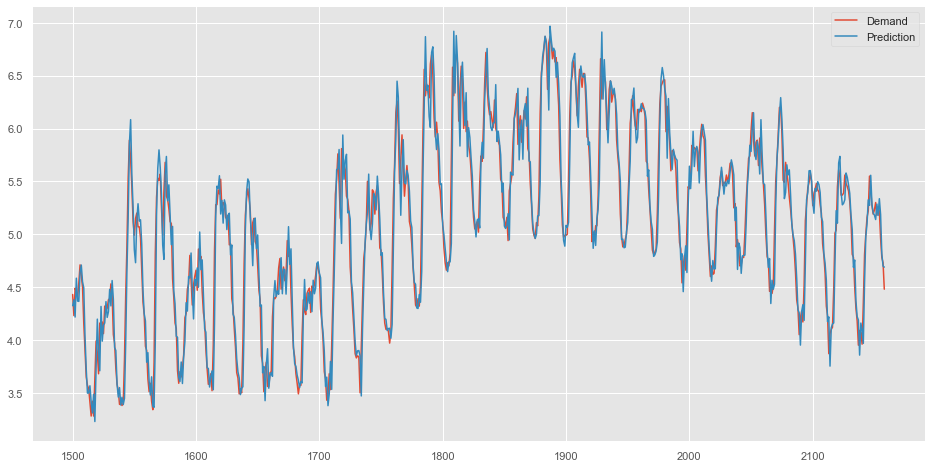

In [248]:
len(df_data)
train_df = df_data.iloc[:1500]
test_df = df_data.iloc[1500:]
mod = SARIMAX(df_data['Demand'], order=(8,1,1), exog=df_data['Temp C'])
res = mod.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end).rename('Prediction')
ax = test_df['Demand'].plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)

In [263]:
df_forecast = pd.read_csv('Forecast_data.csv')

In [268]:
df_forecast.rename(columns={"Temp C?": "Temp C"})

,Date,Temp C,Holiday,Forecast
0,01/01/2018 01:00,1.86,1,NaN
1,01/01/2018 02:00,1.93,1,NaN
2,01/01/2018 03:00,1.36,1,NaN
3,01/01/2018 04:00,1.14,1,NaN
4,01/01/2018 05:00,0.86,1,NaN
...,...,...,...,...
2154,31/03/2018 20:00,15.00,0,NaN
2155,31/03/2018 21:00,13.50,0,NaN
2156,31/03/2018 22:00,13.50,0,NaN
2157,31/03/2018 23:00,12.57,0,NaN


In [269]:
df_forecast.drop(columns=['Forecast'])

,Date,Temp C?,Holiday
0,01/01/2018 01:00,1.86,1
1,01/01/2018 02:00,1.93,1
2,01/01/2018 03:00,1.36,1
3,01/01/2018 04:00,1.14,1
4,01/01/2018 05:00,0.86,1
...,...,...,...
2154,31/03/2018 20:00,15.00,0
2155,31/03/2018 21:00,13.50,0
2156,31/03/2018 22:00,13.50,0
2157,31/03/2018 23:00,12.57,0


<AxesSubplot:>

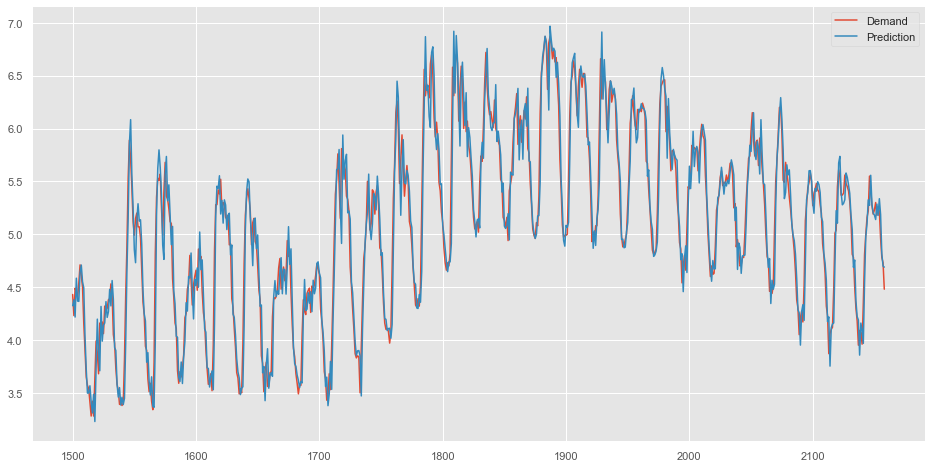

In [306]:
len(df_data)
train_df = df_data.iloc[:1500]
test_df = df_data.iloc[1500:]
mod = SARIMAX(df_data['Demand'], exog=df_data['Temp C'], order=(8,1,1))
res = mod.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end).rename('Prediction')
ax = test_df['Demand'].plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)


In [307]:
res.get_forecast(36)

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.